# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("done loading")

done loading


In [2]:
### To start off let's do a basic data summary.

# number of training examples
n_train = len(X_train)

# number of testing examples
n_test = len(X_test)

# what's the shape of an image?
image_shape = X_train[0].shape

# how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


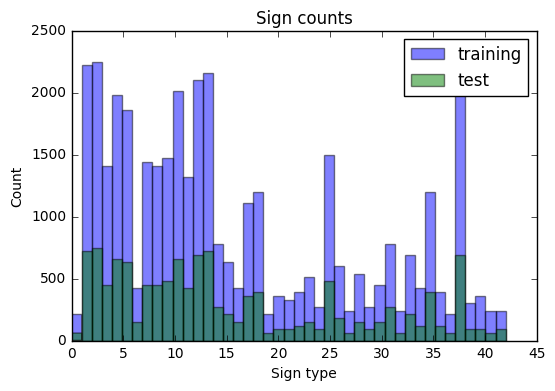

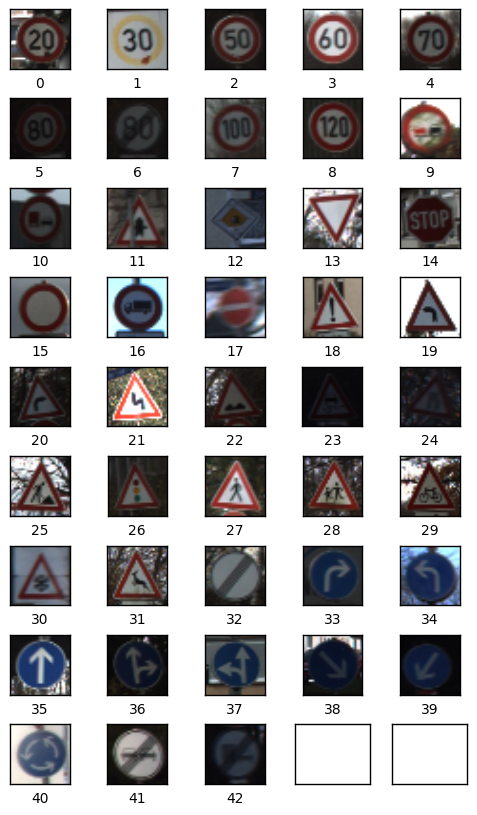

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np

#Histogram of sign types
plt.figure()
n, bins, patches = plt.hist(y_train, bins=43, alpha=0.5, label="training")
n, bins, patches = plt.hist(y_test, bins=43, alpha=0.5, label="test")
plt.title("Sign counts")
plt.xlabel("Sign type")
plt.ylabel("Count")
plt.legend(loc='upper right')
plt.show()

plt.figure()
#Show example of each sign type
images_by_type = dict(zip(y_train, X_train))
fig, axes = plt.subplots(9, 5)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.set_figheight(10)

for i, ax in enumerate(axes.flat):
    if i < n_classes:
        example_image = images_by_type[i]
        # Plot image.
        ax.imshow(example_image)

        xlabel = str(i)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])

# Ensure the plot is shown correctly with multiple plots
# in a single Notebook cell.
plt.show()


#heatmap of sign locations in image
# plt.figure()
# heatmap = np.zeros([image_shape[0], image_shape[1]], dtype=int)
# for size,coords in zip(train['sizes'], train['coords']):
#     scale_matrix = np.mat([[32./float(size[0]), 0.],
#                           [0., 32./float(size[1])]])
#     coords = coords.reshape([2,2])
#     normalized_coords = np.dot(coords, scale_matrix)
#     for x in range(int(normalized_coords[0,0]), int(normalized_coords[1,0])):
#         for y in range(int(normalized_coords[0,1]), int(normalized_coords[1,1])):
#             heatmap[x,y] += 1
#         
# plt.imshow(heatmap, cmap='hot')
# plt.title("Sign location heatmap")
# plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.

# for one-hot encoding
from tensorflow.contrib.learn.python.learn.datasets import mnist

def to_flattened_rgb(image_list):
    return np.array([(np.reshape(i, [1024, 3]))/255. for i in image_list])

X_train = to_flattened_rgb(X_train)
y_train = mnist.dense_to_one_hot(y_train, n_classes)

X_test = to_flattened_rgb(X_test)
y_test = mnist.dense_to_one_hot(y_test, n_classes)

print ("done preprocessing")

done preprocessing


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [5]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [6]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


In [7]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [8]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()

    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [9]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer



In [10]:
import tensorflow as tf

### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# We know that sign images are 32 pixels in each dimension.
img_size = 32

# Images pixels are stored in flattened tensors of this length
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 3

x = tf.placeholder(tf.float32, shape=[None, img_size_flat, num_channels], name='x')

x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, n_classes], name='y_true')

y_true_cls = tf.argmax(y_true, dimension=1)

keep_prob = tf.placeholder(tf.float32)  # dropout (keep probability)

layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

print("conv1: ", layer_conv1)

layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

print("conv2: ", layer_conv2)

layer_flat, num_features = flatten_layer(layer_conv2)

print("flat: ", layer_flat)

print("num_features: ", num_features)

layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

layer_fc1 = tf.nn.dropout(layer_fc1, keep_prob)

print("fc1: ", layer_fc1)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=n_classes,
                         use_relu=False)

print("fc2: ", layer_fc2)

y_pred = tf.nn.softmax(layer_fc2)

top_k = tf.nn.top_k(y_pred, 5)

y_pred_cls = tf.argmax(y_pred, dimension=1)


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



conv1:  Tensor("Relu:0", shape=(?, 16, 16, 16), dtype=float32)
conv2:  Tensor("Relu_1:0", shape=(?, 8, 8, 36), dtype=float32)
flat:  Tensor("Reshape_1:0", shape=(?, 2304), dtype=float32)
num_features:  2304
fc1:  Tensor("dropout/mul:0", shape=(?, 128), dtype=float32)
fc2:  Tensor("add_3:0", shape=(?, 43), dtype=float32)


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

NOTE: My starting point for the network architecture was from this tutorial:
https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb

In [11]:
### Train your model here.
### Feel free to use as many code cells as needed.
current_index = n_train

#Randomized batch of images
def next_batch(batch_size):
    assert batch_size <= n_train
    global current_index, X_train, y_train
    if current_index + batch_size >= n_train:
        current_index = 0
        perm = np.arange(n_train)
        np.random.shuffle(perm)
        X_train = X_train[perm]
        y_train = y_train[perm]
    batch_x, batch_y = X_train[current_index:current_index + batch_size], y_train[current_index:current_index + batch_size]
    current_index += batch_size
    return batch_x, batch_y


In [12]:
import time
from datetime import timedelta


# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    dropout = 0.55

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        train_batch_size = 64
        x_batch, y_true_batch = next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch,
                           keep_prob: dropout}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [13]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(X_test)
    # num_test = 512

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = X_test[i:j, :]

        # Get the associated labels.
        labels = y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels,
                     keep_prob: 1.}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = np.argmax(y_test[:len(cls_pred)], axis=1)

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # # Plot some examples of mis-classifications, if desired.
    # if show_example_errors:
    #     print("Example errors:")
    #     plot_example_errors(cls_pred=cls_pred, correct=correct)
    #
    # # Plot the confusion matrix, if desired.
    # if show_confusion_matrix:
    #     print("Confusion Matrix:")
    #     plot_confusion_matrix(cls_pred=cls_pred)


In [17]:
import os.path

# Add ops to save and restore all the variables.
saver = tf.train.Saver()
checkpoint_name = "model.ckpt"

with tf.Session() as session:

    session.run(tf.initialize_all_variables())
    optimize(num_iterations=100) 
    print_test_accuracy(show_example_errors=True)
    
    optimize(num_iterations=500) # We performed 100 iterations above.
    print_test_accuracy(show_example_errors=True)

    for i in np.arange(20):
        optimize(num_iterations=1000) # We performed 1000 iterations above.
        print_test_accuracy(show_example_errors=True,
                            show_confusion_matrix=True)

    save_path = saver.save(session, checkpoint_name)
    print("Model saved in file: %s" % save_path)



Optimization Iteration:      1, Training Accuracy:   3.1%
Time usage: 0:00:16
Accuracy on Test-Set: 5.8% (735 / 12630)
Optimization Iteration:    101, Training Accuracy:   7.8%
Optimization Iteration:    201, Training Accuracy:   4.7%
Optimization Iteration:    301, Training Accuracy:  17.2%
Optimization Iteration:    401, Training Accuracy:  14.1%
Optimization Iteration:    501, Training Accuracy:  26.6%
Time usage: 0:01:14
Accuracy on Test-Set: 31.2% (3935 / 12630)
Optimization Iteration:    601, Training Accuracy:  23.4%
Optimization Iteration:    701, Training Accuracy:  42.2%
Optimization Iteration:    801, Training Accuracy:  34.4%
Optimization Iteration:    901, Training Accuracy:  40.6%
Optimization Iteration:   1001, Training Accuracy:  46.9%
Optimization Iteration:   1101, Training Accuracy:  53.1%
Optimization Iteration:   1201, Training Accuracy:  48.4%
Optimization Iteration:   1301, Training Accuracy:  57.8%
Optimization Iteration:   1401, Training Accuracy:  46.9%
Optimi

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

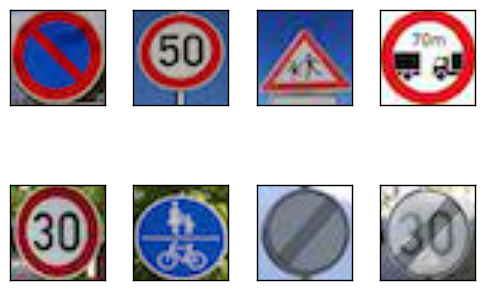

In [18]:
### Load the images and plot them here.
from scipy import misc
import os



def plot_images(images):
    # Create figure sub-plots.
    fig, axes = plt.subplots(2,4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Plot image.
            ax.imshow(images[i])

            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def load_image(filename):
    return misc.imread(filename) 
    
def load_images(path):
    f = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        f.extend([path + '/' + filename for filename in filenames])
        break
    
    return [load_image(filename) for filename in f]

report_images = load_images('report_images')

plot_images(report_images)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [19]:
import tensorflow as tf

report_labels = np.zeros(shape=len(report_images), dtype=np.int)

saver = tf.train.Saver()
checkpoint_name = "model.ckpt"

### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as session:

    # Restore variables from disk.
    saver.restore(session, checkpoint_name)
    
    num_test = len(report_images)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.


    # Create a feed-dict with these images and labels.
    feed_dict = {x: to_flattened_rgb(report_images),
                 y_true: mnist.dense_to_one_hot(report_labels, n_classes),
                 keep_prob: 1.}

    # Calculate the predicted class using TensorFlow.
    (pred, top_k_out) = session.run((y_pred, top_k), feed_dict=feed_dict)
    
    print(np.argmax(pred, axis=1))


[40  5 28 35  1 35  6  6]


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

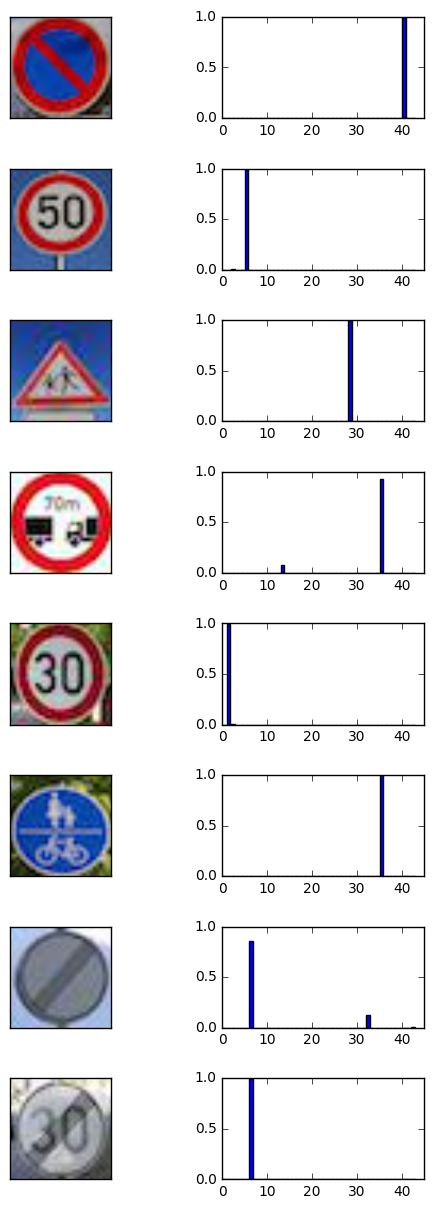

In [24]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
fig, axes = plt.subplots(8,2)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.set_figheight(15)

for i, ax in enumerate(axes.flat):
    if i%2:
        ax.bar(np.arange(n_classes), pred[int(i/2)])
        ax.set_xticks((0,10,20,30,40), minor=False)
        ax.set_yticks((0,0.5,1.), minor=False)
    else:
        ax.imshow(report_images[int(i/2)])
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()
    

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

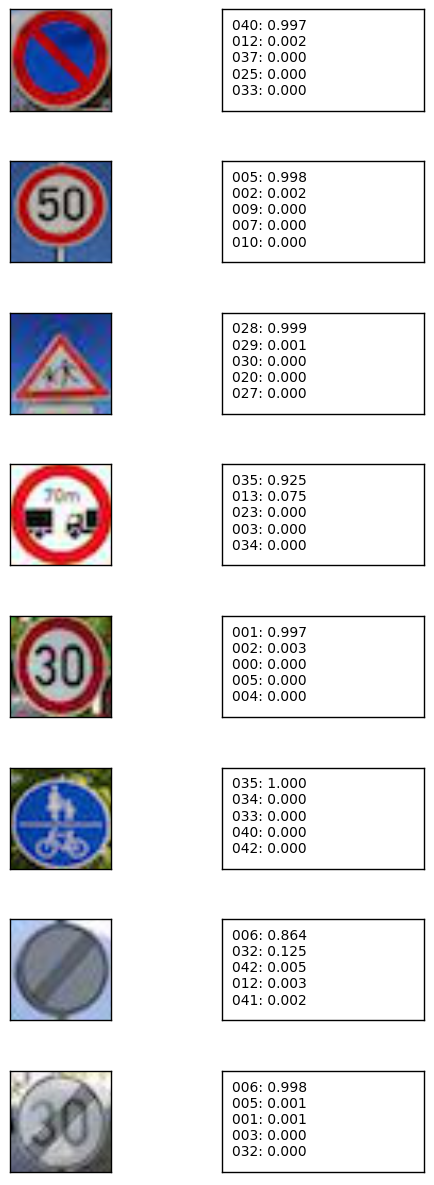

In [25]:
fig, axes = plt.subplots(8,2)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.set_figheight(15)

for i, ax in enumerate(axes.flat):
    index = int(i/2)
    if i%2:
        certainty_str = ""
        for index,certainty in zip(top_k_out.indices[index],top_k_out.values[index]):
            certainty_str += "{:03}: {:.3f}\n".format(index, certainty)
        ax.text(0.05,0, certainty_str, wrap=True)
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.imshow(report_images[int(i/2)])
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()


### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.